## Hyperparameter tuning
- tune hyperparameters for each model (RF, XGB, MLP, GCN) and save the best model for each
- LR is not tuned

In [57]:
import time
import numpy as np

### Load dataset

In [58]:
from dataset import NASBench101Dataset

dataset = NASBench101Dataset('data/nasbench101.hdf5', "172") 
dataset_all = NASBench101Dataset('data/nasbench101.hdf5', "all")

### Get features

In [59]:
from utils import get_targets, get_flat_features, get_flat_features_boosted, get_gcn_features 

**Features for RF, XGB, MLP**

In [60]:
## NOTE: loading all this takes a while (~2min)

# Get train data features and targets
predictor_build_features = get_flat_features(dataset)
predictor_build_targets = get_targets(dataset)

# Get extended train data features (additional features) 
predictor_build_features_ext = get_flat_features_boosted(dataset)

# Get data for applying predictors
all_features = get_flat_features(dataset_all)
all_features_ext = get_flat_features_boosted(dataset_all)
all_targets = get_targets(dataset_all)

In [61]:
# Standard feature set (adjacency + operations)
train_features = predictor_build_features
train_targets = predictor_build_targets

# Extended feature set (adjacency + operations + # weights + conv3x3count)
train_features_ext = predictor_build_features_ext
train_targets_ext = predictor_build_targets

**Features for GCN**

In [62]:
## NOTE: loading all this takes a while (~2min)

# GCN specific features - DAGs
features_gcn = np.array(list([a for a in dataset]))
all_features_gcn = np.array(list([a for a in dataset_all]))

gcn_features_all = [a for a in dataset_all]
gcn_targets_all = get_targets(dataset_all)

### `RFPredictor`

In [63]:
from predictors.random_forest import RFPredictor

In [64]:
rf_predictor = RFPredictor()
start = time.time()

best_hyperparams, best_cv_score = rf_predictor.run_hpo(
    xtrain=train_features,
    ytrain=train_targets,
    metric="kendalltau",
    max_iters=5000,
    k=3, # 3-fold cross validation
    verbose=True,
    start_time=start
)

Starting cross validation
[0/5000] cv_score=0.3865, params={'n_estimators': 116, 'max_features': 0.17055852159745608, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': False}
--> new best score = 0.3865120724100797, hparams = {'n_estimators': 116, 'max_features': 0.17055852159745608, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': False}
patience = 0/50
[1/5000] cv_score=0.4126, params={'n_estimators': 77, 'max_features': 0.5029098999863144, 'min_samples_leaf': 12, 'min_samples_split': 14, 'bootstrap': False}
--> new best score = 0.4125888012106465, hparams = {'n_estimators': 77, 'max_features': 0.5029098999863144, 'min_samples_leaf': 12, 'min_samples_split': 14, 'bootstrap': False}
patience = 0/50
[2/5000] cv_score=0.3810, params={'n_estimators': 42, 'max_features': 0.1298147832695397, 'min_samples_leaf': 9, 'min_samples_split': 17, 'bootstrap': False}
patience = 1/50
[3/5000] cv_score=0.3978, params={'n_estimators': 20, 'max_features': 0.38653544214521374, 'min_

In [65]:
# Set best hyperparameters
rf_predictor.set_hyperparams(best_hyperparams)

# Save predictor
rf_predictor.save("models/rf_tuned.pkl")

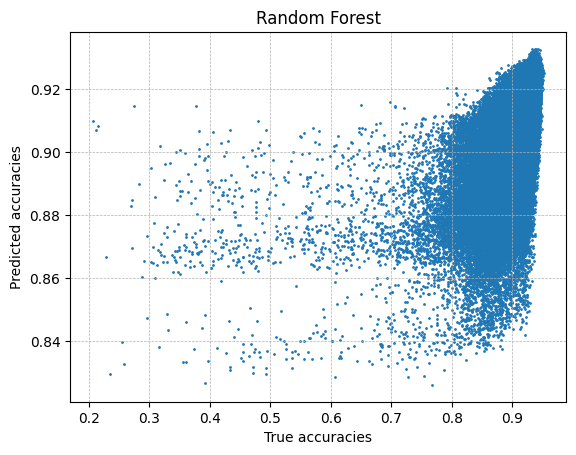

In [66]:
import matplotlib.pyplot as plt

rf_test = RFPredictor()
rf_test.load("models/rf_tuned.pkl")

predictions = rf_test.predict(all_features)

plt.scatter(all_targets, predictions, s=1)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("True accuracies")
plt.ylabel("Predicted accuracies")
plt.title("Random Forest")
plt.show()

### `XGBPredictor`

In [67]:
from predictors.xgb import XGBPredictor

In [68]:
xgb_predictor = XGBPredictor()
start = time.time()

best_hyperparams, best_cv_score = xgb_predictor.run_hpo(
    xtrain=train_features,
    ytrain=train_targets,
    metric="kendalltau",
    max_iters=100, # no need more, cv_score not improving
    k=3, # 3-fold cross validation
    verbose=True,
    start_time=start
)

Starting cross validation
[0/100] cv_score=0.3592, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 1, 'colsample_bytree': 1, 'learning_rate': 0.3, 'colsample_bylevel': 1}
--> new best score = 0.3591814114588278, hparams = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 6, 'min_child_weight': 1, 'colsample_bytree': 1, 'learning_rate': 0.3, 'colsample_bylevel': 1}
patience = 0/50
[1/100] cv_score=0.3592, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 12, 'min_child_weight': 7, 'colsample_bytree': 0.9598306605648377, 'learning_rate': 0.004585831764161761, 'colsample_bylevel': 0.8878470100190147}
patience = 1/50
[2/100] cv_score=0.3592, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 14, 'min_child_weight': 8, 'colsample_bytree': 0.6328050816141182, 'learning_rate': 0.05213397

In [69]:
# Set best hyperparameters
xgb_predictor.set_hyperparams(best_hyperparams)

# Save predictor
xgb_predictor.save("models/xgb_tuned.pkl")

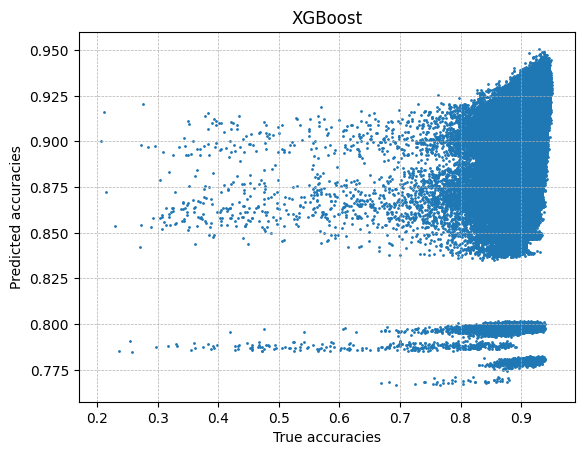

In [70]:
import matplotlib.pyplot as plt

xgb_test = XGBPredictor()
xgb_test.load("models/xgb_tuned.pkl")

predictions = xgb_test.predict(all_features)

plt.scatter(all_targets, predictions, s=1)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("True accuracies")
plt.ylabel("Predicted accuracies")
plt.title("XGBoost")
plt.show()

### `MLPPredictor`

In [71]:
from predictors.mlp import MLPPredictor

In [72]:
# NOTE: tends to overfit
mlp_predictor = MLPPredictor()
start = time.time()

best_hyperparams, best_cv_score = mlp_predictor.run_hpo(
    xtrain=train_features,
    ytrain=train_targets,
    metric="kendalltau",
    max_iters=5000,
    k=3, # 3-fold cross validation
    verbose=True,
    start_time = start
)

Starting cross validation
[05/17 09:15:34] INFO (root) Epoch 1/500, Loss: 2.3225
[05/17 09:15:34] INFO (root) Epoch 2/500, Loss: 2.2995
[05/17 09:15:34] INFO (root) Epoch 3/500, Loss: 2.2759
[05/17 09:15:34] INFO (root) Epoch 4/500, Loss: 2.2530
[05/17 09:15:34] INFO (root) Epoch 5/500, Loss: 2.2300
[05/17 09:15:34] INFO (root) Epoch 6/500, Loss: 2.2079
[05/17 09:15:34] INFO (root) Epoch 7/500, Loss: 2.1858
[05/17 09:15:34] INFO (root) Epoch 8/500, Loss: 2.1638
[05/17 09:15:34] INFO (root) Epoch 9/500, Loss: 2.1410
[05/17 09:15:34] INFO (root) Epoch 10/500, Loss: 2.1194
[05/17 09:15:34] INFO (root) Epoch 11/500, Loss: 2.0964
[05/17 09:15:34] INFO (root) Epoch 12/500, Loss: 2.0745
[05/17 09:15:34] INFO (root) Epoch 13/500, Loss: 2.0517
[05/17 09:15:34] INFO (root) Epoch 14/500, Loss: 2.0268
[05/17 09:15:34] INFO (root) Epoch 15/500, Loss: 2.0015
[05/17 09:15:34] INFO (root) Epoch 16/500, Loss: 1.9720
[05/17 09:15:34] INFO (root) Epoch 17/500, Loss: 1.9404
[05/17 09:15:34] INFO (root) Ep

In [73]:
# Set best hyperparameters
mlp_predictor.set_hyperparams(best_hyperparams)

# Save predictor
mlp_predictor.save("models/mlp_tuned.pkl")

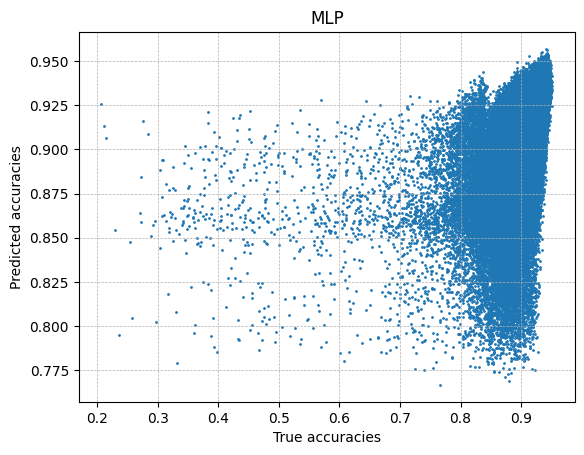

In [74]:
import matplotlib.pyplot as plt

mlp_test = MLPPredictor()
mlp_test.load("models/mlp_tuned.pkl")

predictions = mlp_test.predict(all_features)

plt.scatter(all_targets, predictions, s=1)
plt.xlabel("True accuracies")
plt.ylabel("Predicted accuracies")
plt.grid(linestyle='--', linewidth=0.5)
plt.title("MLP")
plt.show()

### `GCNPredictor`

In [75]:
from predictors.gcn import GCNPredictor

In [76]:
gcn_predictor = GCNPredictor()
start = time.time()

best_hyperparams, best_cv_score = gcn_predictor.run_hpo(
    xtrain=features_gcn,
    ytrain=train_targets,
    metric="kendalltau",
    max_iters=5000,
    k=3, # 3-fold cross validation
    verbose=True,
    start_time = start
)

Starting cross validation
[05/17 09:16:22] INFO (root) Epoch 1/200, Loss: 1.0009, MSE: 5.9697
[05/17 09:16:22] INFO (root) Epoch 2/200, Loss: 1.0006, MSE: 5.9682
[05/17 09:16:22] INFO (root) Epoch 3/200, Loss: 1.0002, MSE: 5.9656
[05/17 09:16:23] INFO (root) Epoch 4/200, Loss: 0.9998, MSE: 5.9631
[05/17 09:16:23] INFO (root) Epoch 5/200, Loss: 0.9994, MSE: 5.9608
[05/17 09:16:23] INFO (root) Epoch 6/200, Loss: 0.9990, MSE: 5.9587
[05/17 09:16:23] INFO (root) Epoch 7/200, Loss: 0.9988, MSE: 5.9572
[05/17 09:16:23] INFO (root) Epoch 8/200, Loss: 0.9986, MSE: 5.9562
[05/17 09:16:23] INFO (root) Epoch 9/200, Loss: 0.9985, MSE: 5.9554
[05/17 09:16:24] INFO (root) Epoch 10/200, Loss: 0.9983, MSE: 5.9545
[05/17 09:16:24] INFO (root) Epoch 11/200, Loss: 0.9981, MSE: 5.9532
[05/17 09:16:24] INFO (root) Epoch 12/200, Loss: 0.9979, MSE: 5.9522
[05/17 09:16:24] INFO (root) Epoch 13/200, Loss: 0.9978, MSE: 5.9512
[05/17 09:16:24] INFO (root) Epoch 14/200, Loss: 0.9976, MSE: 5.9502
[05/17 09:16:24] 

In [77]:
# Set best hyperparameters
gcn_predictor.set_hyperparams(best_hyperparams)

# Save predictor
gcn_predictor.save("models/gcn_tuned.pkl")

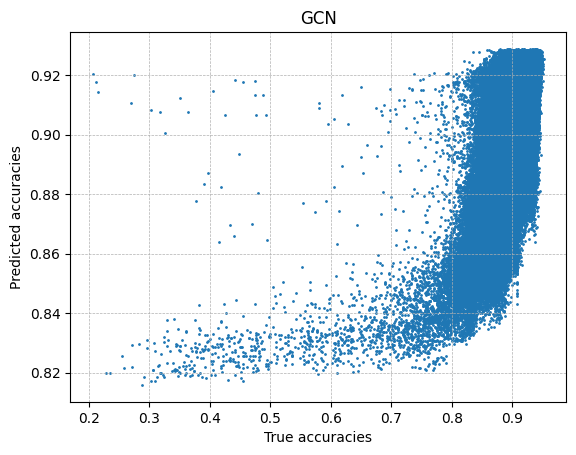

In [78]:
import matplotlib.pyplot as plt

gcn_test = GCNPredictor()
gcn_test.load("models/gcn_tuned.pkl")

predictions = gcn_test.predict(all_features_gcn)

plt.scatter(all_targets, predictions, s=1)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("True accuracies")
plt.ylabel("Predicted accuracies")
plt.title("GCN")
plt.show()